In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import wordcloud
import stop_words
import re
import plotnine as p9
import datetime

%run project_classes_n_code/project_classes_n_code.py

In [38]:
## functions defined in-file
def pattern_searcher(search_str:str, pattern_list:str):

    search_obj = re.search(pattern_list, search_str)
    if search_obj :
        return_str = search_str[search_obj.start(): search_obj.end()]
    else:
        return_str = 'NA'
    return return_str

def extract_pattern_from_list(pd_series, pattern_list, new_col_name = "new_column"):
    pattern = '|'.join(pattern_list)
    return pd_series.apply(lambda x: pattern_searcher(search_str=x, pattern_list=pattern)).rename(new_col_name)

def check_pattern_from_list(pd_series, pattern_list, new_col_name = "new_column"):
    pattern = '|'.join(pattern_list)
    return pd_series.str.contains(pattern).rename(new_col_name)

def check_if_word_mentioned(pd_series, column_name: str, str_list_to_check = []):
    pattern = '|'.join(pattern_list)
    return pd_series.contains(pattern)

In [30]:
timeline = pd.read_csv("timeline.csv")
mentions = pd.read_csv("mentions.csv")
all_pd = timeline.rename({'screen_name':'bank_name'})

# What are banks writing about?

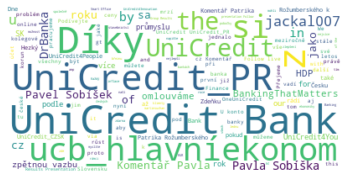

In [34]:
czech_stopwords = stop_words.get_stop_words('czech', cache=True)
text = " ".join(fulltext for fulltext in timeline.full_text)

stopwords = set(czech_stopwords)
stopwords.update(["s", "za", "se", "a", "to", "http", "https", "o", "i", "v", "t", "rt" ])

# Generate a word cloud image
wordcloud_banks = wordcloud.WordCloud(stopwords=stopwords, background_color="white").generate(text)

# Display the generated image:
plt.imshow(wordcloud_banks, interpolation='bilinear')
plt.axis("off")
plt.show()

# But no, really, how often do they mention financial products?

In [69]:
card_words_to_seek = ["card", "karet", "kart"]
timeline['card_mentioned'] = (
    check_pattern_from_list(timeline['full_text'], card_words_to_seek, "card_mentioned")).astype(int)

mentions['card_mentioned'] = (
    check_pattern_from_list(mentions['full_text'], card_words_to_seek, "card_mentioned")).astype(int)

#
mortgage_words_to_seek = ['mortgage', 'hypot', 'bydlen']

timeline['mortgage_mentioned'] = (
    check_pattern_from_list(timeline['full_text'], mortgage_words_to_seek, "mortgage_mentioned")).astype(int)

mentions['mortgage_mentioned'] = (
    check_pattern_from_list(mentions['full_text'], mortgage_words_to_seek, "mortgage_mentioned")).astype(int)

#
banking_words_to_seek = ['banking', 'bankovnic', ' IB', "george"]

timeline['banking_mentioned'] = (
    check_pattern_from_list(timeline['full_text'], banking_words_to_seek, "banking_mentioned")).astype(int)

mentions['banking_mentioned'] = (
    check_pattern_from_list(mentions['full_text'], banking_words_to_seek, "banking_mentioned")).astype(int)


In [80]:
timeline[["screen_name", "banking_mentioned", "mortgage_mentioned", "card_mentioned"]].groupby('screen_name').mean()

,banking_mentioned,mortgage_mentioned,card_mentioned
screen_name,,,
UniCredit_CZSK,0.014245,0.035613,0.038462


In [82]:
mentions[[ "banking_mentioned", "mortgage_mentioned", "card_mentioned"]].mean()

banking_mentioned     0.000000
mortgage_mentioned    0.000000
card_mentioned        0.090909
dtype: float64

# Which language do they use

In [ ]:
lang = all_pd.groupby(["bank_name", "lang"]).count().reset_index()

In [ ]:
(p9.ggplot(lang, p9.aes(x = "bank_name", y = "full_text", fill = "lang"))
+p9.geom_bar(position="stack", stat="identity")
+p9.ggtitle("language distribution per bank"))

# How long does it take them to respond

In [57]:

twitter_datetime_format = "%a %b %d %X %z %Y"
tz_identifier = datetime.timezone(offset = datetime.timedelta(0))
timeline['created_at_datetime'] = (
pd.to_datetime(timeline['created_at'], format=twitter_datetime_format, errors='coerce')
)

timeline['reply_created_at_datetime'] = (
pd.to_datetime(timeline['reply_created_at'], format=twitter_datetime_format, errors='coerce')
)

timeline['reply_time'] = (timeline['created_at_datetime'] - timeline['reply_created_at_datetime']).astype('timedelta64[h]')


C:\Users\RuzicaR\AppData\Local\Continuum\anaconda3\envs\twitter_project\lib\site-packages\plotnine\stats\stat_bin.py:93: PlotnineWarning: 'stat_bin()' using 'bins = 52'. Pick better value with 'binwidth'.


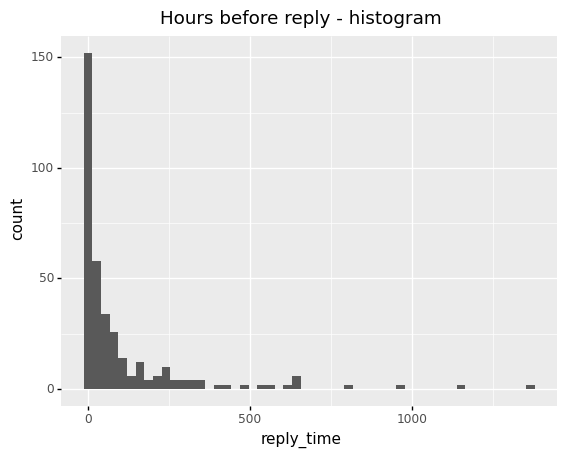

<ggplot: (172653907785)>

In [60]:
p9.ggplot(timeline[['reply_time']].dropna(), p9.aes(x = "reply_time")) + p9.geom_histogram() +p9.ggtitle("Hours before reply - histogram")

# Do they respond quicker to more popular users?

In [63]:
timeline[['reply_friends_count', 'retweet_count', "reply_time"]].dropna().corr()

,reply_friends_count,retweet_count,reply_time
reply_friends_count,1.000000,-0.066885,0.044902
retweet_count,-0.066885,1.000000,-0.010362
reply_time,0.044902,-0.010362,1.000000


No correlation between whether the tweet @ bank was made by a popular (many friends) account. Also no correlation between number of retweets on bank-related statuses and how many friends the account has

# And some summary statistics at the end

In [42]:
all_pd = timeline.rename({'screen_name':'bank_name'})

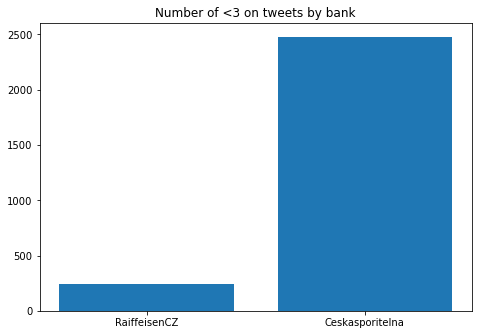

In [96]:

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title('Number of <3 on tweets by bank')
groups = all_pd["bank_name"]
favourites_count = all_pd["favourites_count"]
ax.bar(groups,favourites_count)
plt.show()

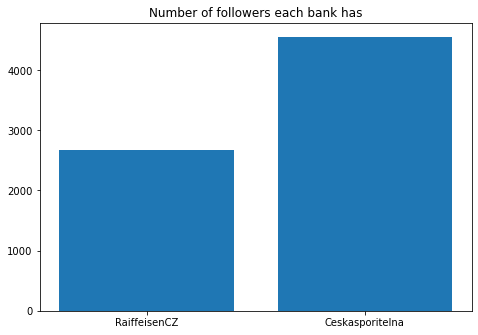

In [95]:

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title('Number of followers each bank has')
groups = all_pd["bank_name"]
favourites_count = all_pd["followers_count"]
ax.bar(groups,favourites_count)
plt.show()

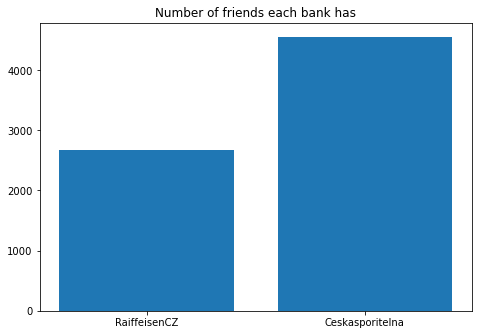

In [74]:

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
groups = all_pd["bank_name"]
favourites_count = all_pd["followers_count"]
ax.set_title('Number of friends each bank has')
ax.bar(groups,favourites_count)
plt.show()

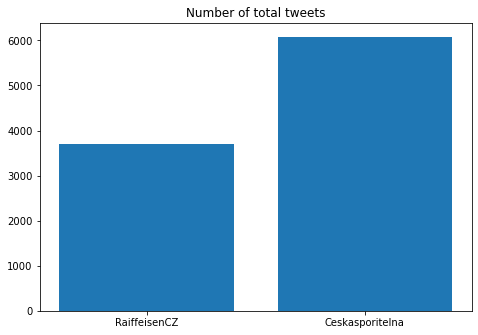

In [72]:

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title('Number of total tweets')
groups = all_pd["bank_name"]
favourites_count = all_pd["statuses_count"]
ax.bar(groups,favourites_count)
plt.show()
